<a href="https://colab.research.google.com/github/deepesh321/Neural_style_transfer/blob/master/neural_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers
#assert tf.enable_eager_execution()
np.random.seed(7)
%matplotlib inline
print(tf.__version__)

TensorFlow 2.x selected.
2.1.0-rc1


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


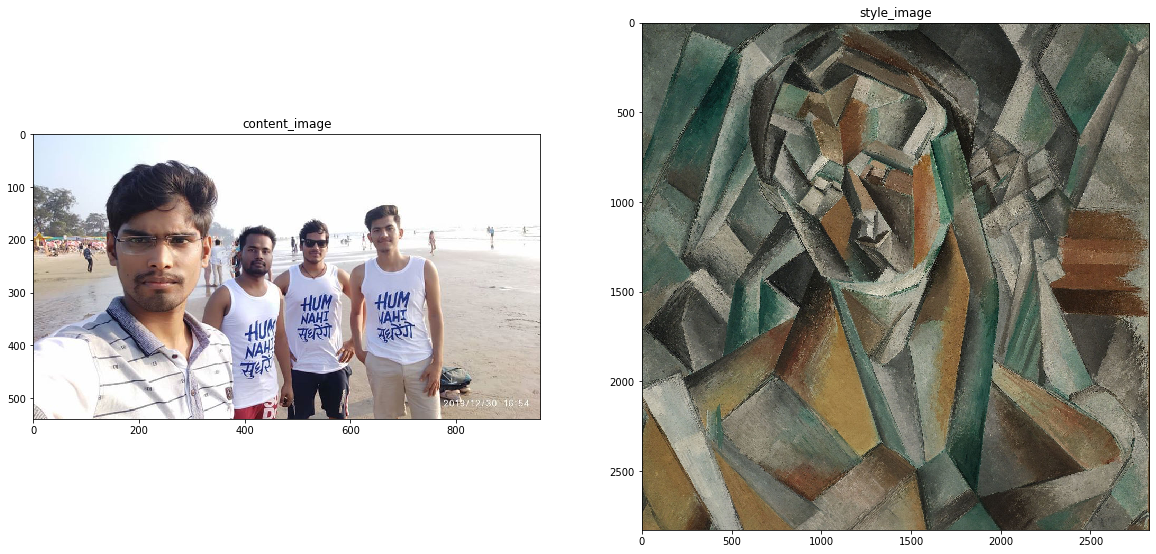

In [3]:
BASE_DIR = '/content/drive/My Drive/neural_style_transfer/'
content=plt.imread(BASE_DIR+'akshay.jpg')
style=plt.imread(BASE_DIR+'picasso.jpg')
fig,(x1,x2)=plt.subplots(1,2,figsize=(20,10))
x1.imshow(content)
x1.set_title('content_image')
x2.imshow(style)
x2.set_title('style_image')
plt.show()

In [0]:
def load_image(img):
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = tf.image.resize(img, [400, 400])
  # Shape -> (batch_size, h, w, d)
  img = img[tf.newaxis, :]
  return img

In [5]:
content=load_image(content)
style=load_image(style)
content.shape,style.shape

(TensorShape([1, 400, 400, 3]), TensorShape([1, 400, 400, 3]))

In [6]:
vgg=tf.keras.applications.VGG19(include_top=False,weights='imagenet')
vgg.trainable=False

80142336/80134624 [==============================] - 1s 0us/step


In [7]:
for layer in vgg.layers:
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [0]:
# Content layer
content_layers = ['block4_conv2']
# Style layer
style_layers = ['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1']
no_of_style_layers=len(style_layers)
no_of_content_layers=len(content_layers)

In [0]:
def my_model(layers,model):
    outputs=[model.get_layer(name).output for name in layers]
    model=Model([vgg.input],outputs)
    return model

In [0]:
def gram_matrix(tensor):
    temp=tensor
    temp=tf.squeeze(temp)
    a=tf.reshape(temp,[temp.shape[2],temp.shape[0]*temp.shape[1]])
    result = tf.matmul(temp, temp, transpose_b=True)
    gram = tf.expand_dims(result, axis=0)
    return gram

In [0]:
class Custom_Style_Model(tf.keras.models.Model):
    def __init__(self,style_layers,content_layers):
        super(Custom_Style_Model, self).__init__()
    
        self.vgg=my_model(style_layers+content_layers,vgg)
        self.style_layers=style_layers
        self.content_layers=content_layers
        self.num_style_layers=len(style_layers)
        self.vgg.trainable=False
        
    def call(self,inputs):
        inputs=inputs*255.0
        preprocessd_input=preprocess_input(inputs)
        outputs=self.vgg(preprocessd_input)
        style_outputs,content_outputs=(outputs[:self.num_style_layers],outputs[self.num_style_layers:])
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]
        content_dict = {content_name:value for content_name, value in zip(self.content_layers, content_outputs)}
        style_dict = {style_name:value for style_name, value in zip(self.style_layers, style_outputs)}

        return {'content':content_dict, 'style':style_dict}


In [0]:
extractor=Custom_Style_Model(style_layers,content_layers)
#print(extractor)
style_targets = extractor(style)['style']
content_targets = extractor(content)['content']

In [0]:
opt = tf.optimizers.Adam(learning_rate=0.02)

In [0]:
style_weight=100
content_weight=10
style_weights = {'block1_conv1': 1.,
                 'block2_conv1': 0.8,
                 'block3_conv1': 0.5,
                 'block4_conv1': 0.3,
                 'block5_conv1': 0.1}

In [0]:
def total_loss(outputs):
    style_outputs=outputs['style']
    content_outputs=outputs['content']
    style_loss=tf.add_n([style_weights[name]*tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss=style_loss*style_weight/no_of_style_layers
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / no_of_content_layers
    loss = style_loss + content_loss
    return loss

In [0]:
@tf.function()
def train(image):
    with tf.GradientTape() as tape:
        outputs=extractor(image)
        loss = total_loss(outputs)
        grad = tape.gradient(loss, image)
        opt.apply_gradients([(grad, image)])
        image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0))

In [0]:
target_image = tf.Variable(content)

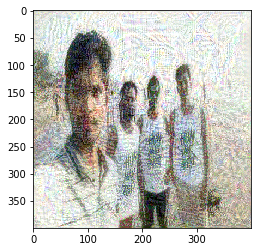

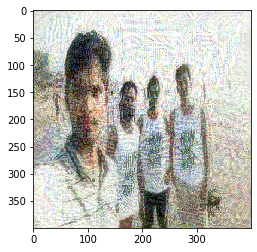

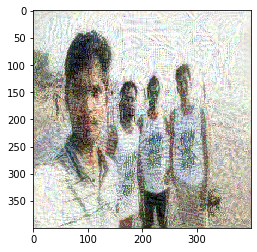

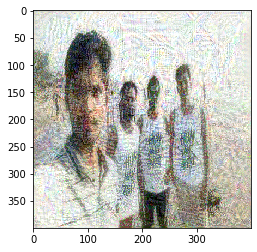

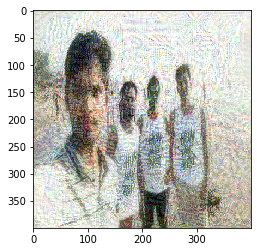

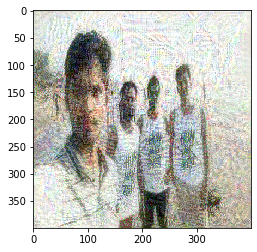

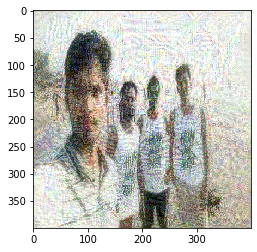

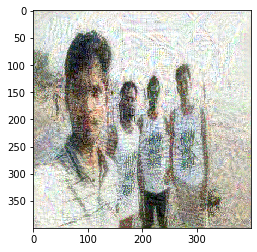

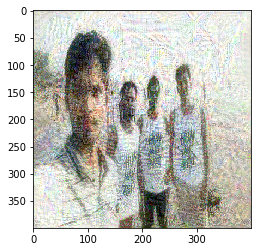

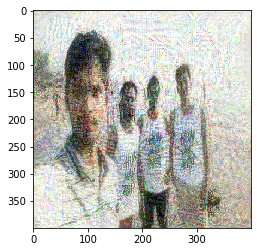

In [20]:
for n in range(10):
    for m in range(10):
        train(target_image)
    plt.imshow(np.squeeze(target_image.read_value(), 0))
    #plt.title("Train step: {}".format(step))
    plt.show()